# Arizona 2020 Primary ERJ
**Additional Election Results Joined to VEST's Precinct Shapefile**

## Notes from VEST's Documentation File:

Election results from Arizona Secretary of State (https://azsos.gov/2020-election-information)
Precinct shapefile from Arizona Secretary of State via personal communication except Greenlee County is sourced from the county shapefile instead.

The following modifications were made to match the precinct boundaries for the 2020 general election.

Apache: Merge Puerco East/West

La Paz: Merge Alamo into Wenden

Maricopa: Merge South Mtn Park E, NE, S, SE, SW into South Mtn Park

- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20USSDKEL - Mark Kelly (Democratic Party)
- G20USSRMCS - Martha McSally (Republican Party)

## Notes on source precinct shapefile file from PDV notebook
VEST does not specify their shapefile source.

The VEST shapefile is the same as the 2018 one from Garrett Archer, except in 17 precincts, where 8 of those 17 precincts are the ones from Grenlee County that VEST subbed in with the county shapefile. [see validation script]

The RDH determined that we will not attempt to validate the VEST 2020 shapefile against the 2018 file from Garrett Archer, because we do not know if the 2018 file is an accurate representation of the geographies of precincts at the time of the 2020 election. We reached out to Garrett Archer on 6/14/2021 to see if he has the 2020 file and did not hear back as of 6/29/2021. 

In [1]:
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import geopandas as gp
import os
from erj_toolbox_archive import *

'''Below pandas functions are essential to the readme displaying properly, 
Be sure to include!'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Precinct Shapefile

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/az_2020/az_2020.shp")
vest_shp.shape

(1489, 9)

In [3]:
vest_shp.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry'],
      dtype='object')

# SOS Election Results
Download primary file from AZ SOS using right click>"save link as" and moved file into existing SOS folder in raw-from-source folder from PDV.

In [4]:
## Election Results XML to df
def read_az_sos_xml(xml_file_path):
    '''xml_file_path refers to the path to the election results
    The roots and attributes called in this function are based on those used by the Arizona SOS in 2020. 
    The general structure can be used for any xml file, but attribute names must be changed.
    '''
    xmlparse = Xet.parse(xml_file_path)
    root = xmlparse.getroot()
    data = []
    lower = root.findall(".//contest")
    for i in lower:
        contest = i.attrib.get('contestLongName')
        lower1 = i.findall('.//choice')
        for j in lower1:
            choice = j.attrib.get('choiceName')
            party = j.attrib.get('party')
            total_votes = j.attrib.get('totalVotes')
            is_write_in = j.attrib.get('isWriteIn')
            lower2 = j.findall('.//jurisdiction')
            for k in lower2:
                jurisdiction_key = k.attrib.get('key')
                jurisdiction_name = k.attrib.get('name')
                jurisdiction_total = k.attrib.get('votes')
                lower3 = k.findall('.//precinct')
                for l in lower3:
                    precinct_key = l.attrib.get('key')
                    precinct_name = l.attrib.get('name').upper()
                    precinct_votes = l.attrib.get('votes')
                    data.append([contest, choice, party, total_votes, is_write_in, jurisdiction_key, jurisdiction_name, jurisdiction_total, 
                                     precinct_key, precinct_name, precinct_votes])
    dfcols = ['contest','choice','party','total_votes','is_write_in','jurisdiction_key','jurisdiction_name','jurisdiction_total',
              'precinct_key','precinct_name','precinct_votes']
    df = pd.DataFrame(data,columns=dfcols)
    #Convert votes to int so numbers can be compared as numbers
    df["precinct_votes"]=df["precinct_votes"].astype(int)
    return df

## Load in all primary election results from SOS as df
**and compare with general election precinct names**

In [5]:
#Load in primary and general election results
gen_xml_path = './raw-from-source/SOS/Results.Detail_2020General.xml'
prim_xml_path = './raw-from-source/SOS/Results.Detail_2020Primary.xml'
gen_df = read_az_sos_xml(gen_xml_path)
print('# unique precinct ids in gen df: ', gen_df.precinct_key.nunique())
prim_df = read_az_sos_xml(prim_xml_path)
print('# unique precinct ids in prim df: ', prim_df.precinct_key.nunique())
print('# precinct names in primary not in general and vice versa - initial: ', len(set(prim_df.precinct_name) - set(gen_df.precinct_name)), 'and', len(set(gen_df.precinct_name)- set(prim_df.precinct_name)))

'''**Here a dictionary to convert primary file precinct names to general file precinct names is applied.** 
This dictionary was created by matching ids based on names that intuitively matched. 
There is a chance that the geographic boundaries do not perfectly match up, even though the names are similar without a *more* similar match.
'''
prim_to_gen_prec_name_dict = { '201-WIKIEUP A/B/D/E':'201-WIKIEUP', '202-WHITE HILLS A/B':'202-WHITE HILLS',
 '203-YUCCA A/B/E/F/G/H':'203-YUCCA','204-CHLORIDE A/B/D/E':'204-CHLORIDE','206-OATMAN A/B/D/E/F/G/H/':'206-OATMAN',
'207-DESERT HILLS A/B/D/E/':'207-DESERT HILLS','208-MEADVIEW A/B':'208-MEADVIEW','209-DOLAN SPRINGS A/B/D':'209-DOLAN SPRINGS',
'210-GOLDEN VALLEY A/B/D/E':'210-GOLDEN VALLEY','212-MOHAVE VALLEY A/B/D/E':'212-MOHAVE VALLEY','213-HACKBERRY A/B/D/E/F/G':'213-HACKBERRY',
 '214-TRUXTON A/B/D/E':'214-TRUXTON','221-LITTLEFIELD A/B/D/E/F':'221-LITTLEFIELD','223-MOCCASIN A':'223-MOCCASIN',
'224-PEACH SPRINGS A/B/D/E':'224-PEACH SPRINGS','56 APACHE JUNCTION NORTH':'56 APACHE JUNCTION  NORTH',
'57 APACHE JUNCTION N CENT':'57 APACHE JUNCTION N. CEN','58 APACHE JUNCTION E CENT':'58 APACHE JUNCTION E. CEN',
 'CLAYPOOL NO. 1':'CLAYPOOL #1','CLAYPOOL NO. 2':'CLAYPOOL #2','CLAYPOOL NO. 3':'CLAYPOOL #3','GLOBE NO. 1':'GLOBE #1',
 'GLOBE NO. 11':'GLOBE #11', 'GLOBE NO. 2':'GLOBE #2', 'GLOBE NO. 3':'GLOBE #3', 'GLOBE NO. 4':'GLOBE #4', 'GLOBE NO. 6':'GLOBE #6',
 'GLOBE NO. 7':'GLOBE #7', 'GLOBE NO. 8':'GLOBE #8', 'MIAMI NO. 1':'MIAMI #1', 'MIAMI NO. 3':'MIAMI #3', 'PAYSON NO. 1':'PAYSON #1',
 'PAYSON NO. 2':'PAYSON #2', 'PAYSON NO. 3':'PAYSON #3', 'PAYSON NO. 4':'PAYSON #4', 'PAYSON NO. 5':'PAYSON #5', 'PAYSON NO. 6':'PAYSON #6', 
'PAYSON NO. 7':'PAYSON #7',
 'PAYSON NO. 8':'PAYSON #8','PINE-STRAWBERRY WEST': 'PINE STRAWBERRY WEST','1.01':'PRECINCT 001','2':'PRECINCT 002',
 '3':'PRECINCT 003', '4':'PRECINCT 004','5':'PRECINCT 005', '6':'PRECINCT 006', '7':'PRECINCT 007', '8.01':'PRECINCT 008',
 '9':'PRECINCT 009', '10':'PRECINCT 010', '11':'PRECINCT 011', '12':'PRECINCT 012', '13':'PRECINCT 013', '14.01':'PRECINCT 014',
 '15.01':'PRECINCT 015', '16':'PRECINCT 016', '17':'PRECINCT 017', '18':'PRECINCT 018', '19':'PRECINCT 019', '20':'PRECINCT 020',
 '21':'PRECINCT 021', '22':'PRECINCT 022', '23.01':'PRECINCT 023', '24.01':'PRECINCT 024', '25.01':'PRECINCT 025', '26':'PRECINCT 026',
'27':'PRECINCT 027', '28':'PRECINCT 028', '29':'PRECINCT 029', '30.01':'PRECINCT 030', '31':'PRECINCT 031', '32':'PRECINCT 032',
 '33':'PRECINCT 033', '34.01':'PRECINCT 034', '35':'PRECINCT 035', '36':'PRECINCT 036', '37':'PRECINCT 037', '38':'PRECINCT 038',
'39':'PRECINCT 039', '40':'PRECINCT 040', '41.01':'PRECINCT 041', '42':'PRECINCT 042', '43':'PRECINCT 043', '44':'PRECINCT 044'}

prim_df['precinct_name_old'] = prim_df['precinct_name']
prim_df.loc[prim_df['precinct_name_old'].isin(prim_to_gen_prec_name_dict.keys()), 'precinct_name'] = prim_df.precinct_name.map(prim_to_gen_prec_name_dict)
print('# precinct names in primary not in general and vice versa - after dictionary transformation: ', len(set(prim_df.precinct_name) - set(gen_df.precinct_name)), 'and', len(set(gen_df.precinct_name)- set(prim_df.precinct_name)))
#Now just working with prim_df so will rename df
df = prim_df
df = df[df['is_write_in']!='true']

# unique precinct ids in gen df:  1489
# unique precinct ids in prim df:  1489
# precinct names in primary not in general and vice versa - initial:  84 and 84
# precinct names in primary not in general and vice versa - after dictionary transformation:  0 and 0


In [6]:
df.columns

Index(['contest', 'choice', 'party', 'total_votes', 'is_write_in',
       'jurisdiction_key', 'jurisdiction_name', 'jurisdiction_total',
       'precinct_key', 'precinct_name', 'precinct_votes', 'precinct_name_old'],
      dtype='object')

## Add district numbers to primary election df + create district-precinct ids
Now that the precinct ids are ready to go/match general, proceed with adding district info/formatting to join with VEST.
</br>Note this district splitting was not an issue in the initial round of PDV because sldl, sldu and usreps were not included
</br>Be careful to make sure votes properly distributed/split!

In [7]:
#Add district # as column to identify US House, State House/Senate districts where appropriate
#state senator
df['sldu_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('State Senator' in x)), 'sldu_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('State Senator' in x)),'contest'].str.slice(start = -8, stop = -6)
#state representative
df['sldl_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('State Representative' in x)), 'sldl_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('State Representative' in x)),'contest'].str.slice(start = -8, stop = -6)
#US House
df['usrep_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('U.S. Representative' in x)), 'usrep_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('U.S. Representative' in x)), 'contest'].str.slice(start = -8, stop = -6)

df['sldl_dist'] = df['sldl_dist'].str.replace(' ', '0').str.zfill(2)
df['sldu_dist'] = df['sldu_dist'].str.replace(' ', '0').str.zfill(2)
df['usrep_dist'] = df['usrep_dist'].str.replace(' ', '0').str.zfill(2)

df['prec_id_sldl_sldu_usrep'] = mk_precinct_district_id(df, 'precinct_key', 'sldl_dist', 'sldu_dist', 'usrep_dist')
prec_split_check(df, 'precinct_name', vest_shp, 'PCTNUM', 'sldl_dist', 'sldu_dist', 'usrep_dist', 'prec_id_sldl_sldu_usrep')

# vest unique precinct ids:  1489 
 # sos unique precinct ids:  1489 
 # sos ids with districts attached:  1489
Counts match - no splits occurred!


<ipython-input-7-3e7fc4222b3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sldu_dist'] = 'NA'
/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-7-3e7fc4222b3a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

## Create column headers based on contest

In [8]:
df.head(1)

,contest,choice,party,total_votes,is_write_in,jurisdiction_key,jurisdiction_name,jurisdiction_total,precinct_key,precinct_name,precinct_votes,precinct_name_old,sldu_dist,sldl_dist,usrep_dist,prec_sldl_id_og,prec_sldu_id_og,prec_usrep_id_og,prec_sldl_id_toall,prec_sldu_id_toall,prec_usrep_id_toall,prec_id_sldl_sldu_usrep
1489,U.S. Senator (DEM),"Kelly, Mark",DEM,665620,false,1,Apache,9864,8816,02 ALPINE,49,02 ALPINE,NA,NA,NA,NaN,NaN,NaN,8816-07,8816-07,8816-01,[8816-07][8816-07][8816-01]


In [9]:
contest_col='contest'
election_type = 'P'
election_year = '20'
df['party_1char'] = df['party'].str.slice(stop = 1)
df['party_3char'] = df['party']
df['choice_3char'] = df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 3)
df['prop_number'] = df['contest'].str.slice(start = -3)
df['prop_choice'] = df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 1)
#df['sldl_dist'] = df['sldl_dist'].map(lambda x: "".join(filter(str.isalnum, x)))
#df['sldu_dist'] = df['sldu_dist'].map(lambda x: "".join(filter(str.isalnum, x)))
#at_large = True
df['usrep_dist'] = df['usrep_dist'].map(lambda x: "".join(filter(str.isalnum, x)))

df['field_id'] = create_field_id(df, contest_col, election_type, election_year, 
                                party_1char='party_1char', party_3char='party_3char', choice_3char='choice_3char',
                                 prop_number='prop_number', prop_choice='prop_choice')    

<ipython-input-9-7804cdc6f3a0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['party_1char'] = df['party'].str.slice(stop = 1)
<ipython-input-9-7804cdc6f3a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['party_3char'] = df['party']
<ipython-input-9-7804cdc6f3a0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [10]:
df.field_id.value_counts()

P20COCDTOV    1489
P20COCRMAR    1489
P20USSDKEL    1489
P20COCDSTA    1489
P20COCRSLO    1489
P20USSRMCS    1489
P20COCDMUN    1489
P20USSRMCC    1489
PCON08DMUS     286
PCON01RSHE     279
PCON01DOHA     279
PCON01DPUT     279
PCON01RREI     279
PCON02DKIR     195
PCON02RMAR     195
PCON02RRUD     195
PCON02DQUI     195
PCON02RMOR     195
PCON03RWOO     178
PCON03DGRI     178
PCON04RWAR     162
PCON04DDIS     162
PCON04DSTA     162
PCON04RGOS     162
PCON06RSCH     157
PCON06DMAL     157
PCON06DRIM     157
PCON06DGEN     157
PCON06DTIP     157
PCON08DOLS     143
PCON08RLES     143
PCON09RHUA     140
PCON09RGIL     140
PCON09DSTA     140
PCON09RTUT     140
PCON05DRAM     128
PCON05RBIG     128
PCON05DGRE     128
PCON05DIRE     128
PCON07RBAR     107
PCON07DGAL     107
PSL10DSTA       98
PSL14DMAE       95
PSU14RGOW       95
PSL14DBEA       95
PSL14RGRI       95
PSL14RNUT       95
PSU14DKAR       95
PSU07DPES       87
PSL07RPAR       87
PSL07DTEL       87
PSL07RPEE       87
PSL07DTSO   

## Pivot primary election results

### Checks

In [11]:
# Jurisdiction (County) key and values map one to one: (can use either one for pivot)
(df.jurisdiction_key.value_counts().values == df.jurisdiction_name.value_counts().values).all()

True

In [12]:
# Precinct key and values map one to one: (can use either one for pivot)
(df.precinct_key.value_counts().values == df.precinct_name.value_counts().values).all()

True

In [13]:
# Precinct key and prec_district_ids map one to one: (can use either one for pivot)
(df.precinct_key.value_counts().values == df.prec_id_sldl_sldu_usrep.value_counts().values).all()

True

### Pivot

In [14]:
prec_row_df = pd.pivot_table(df, index = ['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep'], 
                             columns = ['field_id'], 
                             values = ['precinct_votes'], 
                             aggfunc = np.sum)
prec_row_df.head(2)

precinct_votes  \
field_id                                                              P20COCDMUN   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                      
Apache            02 ALPINE           [8816-07][8816-07][8816-01]           31.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]          427.0   

                                                                              \
field_id                                                          P20COCDSTA   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       27.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]      365.0   

                                                                              \
field_id                                                          P20COCDTOV   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       36.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]      403.0   

                                                                              \
field_id                                                          P20COCRMAR   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       68.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]       47.0   

                                                                              \
field_id                                                          P20COCRSLO   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]      102.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]       60.0   

                                                                              \
field_id                                                          P20USSDKEL   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       49.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]      746.0   

                                                                              \
field_id                                                          P20USSRMCC   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       32.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]       26.0   

                                                                              \
field_id                                                          P20USSRMCS   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]      106.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]       60.0   

                                                                              \
field_id                                                          PCON01DOHA   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       25.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]      570.0   

                                                                              \
field_id                                                          PCON01DPUT   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [8816-07][8816-07][8816-01]       22.0   
                  03 CANYON DE CHELLY [8817-07][8817-07][8817-01]      182.0   

                                    

In [15]:
#rename columns
prec_row_df.columns = prec_row_df.columns.to_series().str.join(' ')
prec_row_df = prec_row_df.fillna(0)
prec_row_df.reset_index(inplace=True)
prec_row_df.columns = prec_row_df.columns.map(lambda x : x if 'precinct_votes ' not in x else  x[len('precinct_votes '):])
prec_row_df.head()

,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,P20COCDMUN,P20COCDSTA,P20COCDTOV,P20COCRMAR,P20COCRSLO,P20USSDKEL,P20USSRMCC,P20USSRMCS,PCON01DOHA,PCON01DPUT,PCON01RREI,PCON01RSHE,PCON02DKIR,PCON02DQUI,PCON02RMAR,PCON02RMOR,PCON02RRUD,PCON03DGRI,PCON03RWOO,PCON04DDIS,PCON04DSTA,PCON04RGOS,PCON04RWAR,PCON05DGRE,PCON05DIRE,PCON05DRAM,PCON05RBIG,PCON06DGEN,PCON06DMAL,PCON06DRIM,PCON06DTIP,PCON06RSCH,PCON07DGAL,PCON07RBAR,PCON08DMUS,PCON08DOLS,PCON08RLES,PCON09DSTA,PCON09RGIL,PCON09RHUA,PCON09RTUT,PSL01DSTA,PSL01RBLI,PSL01RBUR,PSL01RCOC,PSL01RNGU,PSL01RSEN,PSL02DDAL,PSL02DHER,PSL02DPAR,PSL02DPEA,PSL02RMCE,PSL03DCAN,PSL03DHER,PSL03DSOT,PSL04DFER,PSL04DPET,PSL04RJOH,PSL05RBIA,PSL05RCOB,PSL06DEVA,PSL06RBAR,PSL06RBLA,PSL07DTEL,PSL07DTSO,PSL07RPAR,PSL07RPEE,PSL08DGIR,PSL08RCAR,PSL08RCOO,PSL08RPRA,PSL09DFRI,PSL09DPOW,PSL09RLYO,PSL10DDEG,PSL10DSTA,PSL10RGUM,PSL10RHIC,PSL11DPER,PSL11RFIN,PSL11RROB,PSL12RGRA,PSL12RHOF,PSL13DSAN,PSL13RDUN,PSL13RMON,PSL13ROSB,PSL14DBEA,PSL14DMAE,PSL14RGRI,PSL14RNUT,PSL15DDYB,PSL15RHAM,PSL15RKAI,PSL15RWIL,PSL16RFIL,PSL16RGOD,PSL16RMOR,PSL16RPAR,PSL17DPAW,PSL17RHAR,PSL17RWEN,PSL18DEPS,PSL18DJER,PSL18RROB,PSL19DESP,PSL19DSIE,PSL19DSUN,PSL20DSCH,PSL20RBOL,PSL20RKER,PSL21DKNE,PSL21RMIL,PSL21RPAY,PSL21RPIN,PSL22DGAR,PSL22DHON,PSL22RCAR,PSL22RTOM,PSL23DKUR,PSL23RCHA,PSL23RKAV,PSL23RLAW,PSL24DLON,PSL24DSHA,PSL25DHUG,PSL25RBOW,PSL25RPEA,PSL25RUDA,PSL26DHER,PSL26DMOR,PSL26DNEZ,PSL26DSAL,PSL26RLOU,PSL26RSIF,PSL27DBOL,PSL27DMIR,PSL27DROD,PSL27RPEÑ,PSL28DBUT,PSL28DLIE,PSL28RBOW,PSL28RJAC,PSL29DAND,PSL29DCAS,PSL29DCHA,PSL29RBRA,PSL29RFOK,PSL29RMCM,PSL30DMEZ,PSL30DTER,PSU01RFAN,PSU02DGAB,PSU02RWOR,PSU03DGON,PSU04DOTO,PSU04RANG,PSU05RBOR,PSU06DFRE,PSU06RALL,PSU06RROG,PSU07DPES,PSU08DMCG,PSU08RSHO,PSU09DSTE,PSU10DENG,PSU10RWAD,PSU11DMEN,PSU11DPAT,PSU11RLEA,PSU12DROB,PSU12RPET,PSU13RKER,PSU14DKAR,PSU14RGOW,PSU15RBAR,PSU15RCAR,PSU16RTOW,PSU17DKUR,PSU17RMES,PSU18DBOW,PSU18RSHA,PSU19DCHA,PSU20DERV,PSU20RBOY,PSU21RGRA,PSU22DTYR,PSU22RDIC,PSU22RLIV,PSU22RNGU,PSU23DBLA,PSU23RKOL,PSU23RUGE,PSU24DALS,PSU24DSTA,PSU25DWEI,PSU25RPAC,PSU26DGRA,PSU26DMEN,PSU26RCHI,PSU27DRIO,PSU27RSHR,PSU28DMAR,PSU28RBRO,PSU29DQUE,PSU29RWIL,PSU30DNAV
0,Apache,02 ALPINE,[8816-07][8816-07][8816-01],31.0,27.0,36.0,68.0,102.0,49.0,32.0,106.0,25.0,22.0,71.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,31.0,88.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Apache,03 CANYON DE CHELLY,[8817-07][8817-07][8817-01],427.0,365.0,403.0,47.0,60.0,746.0,26.0,60.0,570.0,182.0,33.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0,594.0,58.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Apache,05 CHINLE,[8818-07

In [16]:
#Assign district numbers to separate column
prec_row_df['SL_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = 6, stop = 8)
prec_row_df.loc[prec_row_df['prec_id_sldl_sldu_usrep'].str.startswith('[10'), 'SL_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = 7, stop = 9)
prec_row_df['SL_DIST'] = prec_row_df['SL_DIST'].str.replace(' ', '0').str.zfill(2)
prec_row_df['SLDL_DIST'] = prec_row_df['SL_DIST']
prec_row_df['SLDU_DIST'] = prec_row_df['SL_DIST']
prec_row_df['CON_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = -3, stop = -1).str.replace(' ', '0').str.zfill(2)

In [17]:
#Check district result
for col in prec_row_df[prec_row_df['SL_DIST']=='01'].columns:
    if (prec_row_df[col][prec_row_df['SL_DIST']=='01'].sum() != 0)&('PSL' in col):
        print(col, prec_row_df[col][prec_row_df['SL_DIST']=='01'].sum())

PSL01DSTA 19199.0
PSL01RBLI 18773.0
PSL01RBUR 21184.0
PSL01RCOC 9573.0
PSL01RNGU 27275.0
PSL01RSEN 12968.0


# Prepare to validate election results
- Check district/statewide level results manually

## Add county fips to df and to VEST file

In [18]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Arizona"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
az_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

prec_row_df['COUNTYFP'] = prec_row_df['jurisdiction_name'].apply(lambda x: az_fips_dict.get(x))

#FOR VEST FILE
#Map VEST county name abbreviations to county names
cde_county_dict = {'AP':'Apache', 'CH':'Cochise', 'CN':'Coconino', 'GI':'Gila', 'GM':'Graham', 'LP':'La Paz', 'MO':'Mohave', 'PN':'Pinal', 'SC':'Santa Cruz', 'YA':'Yavapai', 'NA':'Navajo',
       'YU':'Yuma', 'MC':'Maricopa', 'PM':'Pima', 'GN':'Greenlee'}

#Use above mapping to create county fips column
vest_shp['county_name'] = vest_shp['CDE_COUNTY'].apply(lambda x: cde_county_dict.get(x))
vest_shp['COUNTYFP'] = vest_shp['county_name'].apply(lambda x: az_fips_dict.get(x)).str.zfill(3)

## Merge SOS Election Results and VEST's

In [19]:
vest_shp.shape

(1489, 11)

In [20]:
prec_row_df.shape

(1489, 215)

In [21]:
prec_row_df['precinct_name'].nunique()

1489

In [22]:
prec_row_df.columns

Index(['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep',
       'P20COCDMUN', 'P20COCDSTA', 'P20COCDTOV', 'P20COCRMAR', 'P20COCRSLO',
       'P20USSDKEL', 'P20USSRMCC',
       ...
       'PSU28DMAR', 'PSU28RBRO', 'PSU29DQUE', 'PSU29RWIL', 'PSU30DNAV',
       'SL_DIST', 'SLDL_DIST', 'SLDU_DIST', 'CON_DIST', 'COUNTYFP'],
      dtype='object', length=215)

**During validation for PDV, did join attempt 1, then wrote to shp, then matched below by hand**
</br>Notes: 
- Gila County (007): compare VEST P/S EAST and P/S WEST with SOS
- Graham County (009): need to use the PCTNUM to figure out the 3 SAFFORD precincts
</br>Lined up all of the precincts by hand and loaded back in as dictionary file. 

## Read in csv made during PDV to match counties and precincts for join

In [23]:
precinct_dictionary_csv = pd.read_csv('election_results_dictionary.csv', dtype = {'COUNTYFP_vest':'object','COUNTYFP_sos':'object'})

vest_shp_merged = vest_shp.merge(precinct_dictionary_csv, how = 'outer', left_on = ['PCTNUM'], 
                                                right_on = ['PCTNUM_vest'], indicator = True)
vest_shp_merged.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos
_merge,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489


In [24]:
vest_shp_merged.shape

(1489, 19)

## Join vest df to processed SOS df

In [25]:
#df vest merged with updated pct names to join to sos
vest_shp_merged.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry', 'county_name',
       'COUNTYFP', 'COUNTYFP_vest', 'PCTNUM_vest', 'PRECINCTNA_vest',
       'G20PREDBID_vest', 'COUNTYFP_sos', 'precinct_name_sos',
       'G20PREDBID_sos', '_merge'],
      dtype='object')

**Joining using sos precinct name since it is actually unique**

In [26]:
vest_shp_merged.drop(columns = ['_merge'], inplace = True)
#merge
vest_shp_merged['precinct_name_sos']=vest_shp_merged['precinct_name_sos'].str.upper()
df_joined_to_vest = vest_shp_merged.merge(prec_row_df, how = 'outer'
                            , left_on = ['COUNTYFP','precinct_name_sos'], right_on = ['COUNTYFP','precinct_name'], 
                                          suffixes=('_x', ''), indicator = True)

In [27]:
df_joined_to_vest.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,P20COCDMUN,P20COCDSTA,P20COCDTOV,P20COCRMAR,P20COCRSLO,P20USSDKEL,P20USSRMCC,P20USSRMCS,PCON01DOHA,PCON01DPUT,PCON01RREI,PCON01RSHE,PCON02DKIR,PCON02DQUI,PCON02RMAR,PCON02RMOR,PCON02RRUD,PCON03DGRI,PCON03RWOO,PCON04DDIS,PCON04DSTA,PCON04RGOS,PCON04RWAR,PCON05DGRE,PCON05DIRE,PCON05DRAM,PCON05RBIG,PCON06DGEN,PCON06DMAL,PCON06DRIM,PCON06DTIP,PCON06RSCH,PCON07DGAL,PCON07RBAR,PCON08DMUS,PCON08DOLS,PCON08RLES,PCON09DSTA,PCON09RGIL,PCON09RHUA,PCON09RTUT,PSL01DSTA,PSL01RBLI,PSL01RBUR,PSL01RCOC,PSL01RNGU,PSL01RSEN,PSL02DDAL,PSL02DHER,PSL02DPAR,PSL02DPEA,PSL02RMCE,PSL03DCAN,PSL03DHER,PSL03DSOT,PSL04DFER,PSL04DPET,PSL04RJOH,PSL05RBIA,PSL05RCOB,PSL06DEVA,PSL06RBAR,PSL06RBLA,PSL07DTEL,PSL07DTSO,PSL07RPAR,PSL07RPEE,PSL08DGIR,PSL08RCAR,PSL08RCOO,PSL08RPRA,PSL09DFRI,PSL09DPOW,PSL09RLYO,PSL10DDEG,PSL10DSTA,PSL10RGUM,PSL10RHIC,PSL11DPER,PSL11RFIN,PSL11RROB,PSL12RGRA,PSL12RHOF,PSL13DSAN,PSL13RDUN,PSL13RMON,PSL13ROSB,PSL14DBEA,PSL14DMAE,PSL14RGRI,PSL14RNUT,PSL15DDYB,PSL15RHAM,PSL15RKAI,PSL15RWIL,PSL16RFIL,PSL16RGOD,PSL16RMOR,PSL16RPAR,PSL17DPAW,PSL17RHAR,PSL17RWEN,PSL18DEPS,PSL18DJER,PSL18RROB,PSL19DESP,PSL19DSIE,PSL19DSUN,PSL20DSCH,PSL20RBOL,PSL20RKER,PSL21DKNE,PSL21RMIL,PSL21RPAY,PSL21RPIN,PSL22DGAR,PSL22DHON,PSL22RCAR,PSL22RTOM,PSL23DKUR,PSL23RCHA,PSL23RKAV,PSL23RLAW,PSL24DLON,PSL24DSHA,PSL25DHUG,PSL25RBOW,PSL25RPEA,PSL25RUDA,PSL26DHER,PSL26DMOR,PSL26DNEZ,PSL26DSAL,PSL26RLOU,PSL26RSIF,PSL27DBOL,PSL27DMIR,PSL27DROD,PSL27RPEÑ,PSL28DBUT,PSL28DLIE,PSL28RBOW,PSL28RJAC,PSL29DAND,PSL29DCAS,PSL29DCHA,PSL29RBRA,PSL29RFOK,PSL29RMCM,PSL30DMEZ,PSL30DTER,PSU01RFAN,PSU02DGAB,PSU02RWOR,PSU03DGON,PSU04DOTO,PSU04RANG,PSU05RBOR,PSU06DFRE,PSU06RALL,PSU06RROG,PSU07DPES,PSU08DMCG,PSU08RSHO,PSU09DSTE,PSU10DENG,PSU10RWAD,PSU11DMEN,PSU11DPAT,PSU11RLEA,PSU12DROB,PSU12RPET,PSU13RKER,PSU14DKAR,PSU14RGOW,PSU15RBAR,PSU15RCAR,PSU16RTOW,PSU17DKUR,PSU17RMES,PSU18DBOW,PSU18RSHA,PSU19DCHA,PSU20DERV,PSU20RBOY,PSU21RGRA,PSU22DTYR,PSU22RDIC,PSU22RLIV,PSU22RNGU,PSU23DBLA,PSU23RKOL,PSU23RUGE,PSU24DALS,PSU24DSTA,PSU25DWEI,PSU25RPAC,PSU26DGRA,PSU26DMEN,PSU26RCHI,PSU27DRIO,PSU27RSHR,PSU28DMAR,PSU28RBRO,PSU29DQUE,PSU29RWIL,PSU30DNAV,SL_DIST,SLDL_DIST,SLDU_DIST,CON_DIST
_merge,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489

# Create final gdf 
- Format columns to be in intuitive order based on race

We assured ourselves that our formatted results matched VEST's, VEST's file is used as the geographic data source since a raw shapefile was not available.

In [28]:
uss_list = select_cols(prec_row_df, 'P20USS')
con_list = select_cols(prec_row_df, 'PCON')
coc_list = select_cols(prec_row_df, 'P20COC')
slu_list = select_cols(prec_row_df, 'PSU')
sll_list = select_cols(prec_row_df, 'PSL')
election_columns = uss_list + con_list + coc_list + slu_list + sll_list

df_joined_to_vest['UNIQUE_ID'] = df_joined_to_vest['precinct_name']
df_joined_to_vest['COUNTY_NAM'] = df_joined_to_vest['county_name']
location_desc_cols = ['UNIQUE_ID', 'COUNTYFP', 'PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'COUNTY_NAM', 'CON_DIST', 'SLDL_DIST', 'SLDU_DIST']
geo_col = ['geometry']

final_column_order = format_erj_cols(location_desc_cols, election_columns, geo_col)
gdf = df_joined_to_vest[final_column_order]

In [29]:
gdf.head()

,UNIQUE_ID,COUNTYFP,PCTNUM,PRECINCTNA,CDE_COUNTY,COUNTY_NAM,CON_DIST,SLDL_DIST,SLDU_DIST,P20USSDKEL,P20USSRMCC,P20USSRMCS,PCON01DOHA,PCON01DPUT,PCON01RREI,PCON01RSHE,PCON02DKIR,PCON02DQUI,PCON02RMAR,PCON02RMOR,PCON02RRUD,PCON03DGRI,PCON03RWOO,PCON04DDIS,PCON04DSTA,PCON04RGOS,PCON04RWAR,PCON05DGRE,PCON05DIRE,PCON05DRAM,PCON05RBIG,PCON06DGEN,PCON06DMAL,PCON06DRIM,PCON06DTIP,PCON06RSCH,PCON07DGAL,PCON07RBAR,PCON08DMUS,PCON08DOLS,PCON08RLES,PCON09DSTA,PCON09RGIL,PCON09RHUA,PCON09RTUT,P20COCDMUN,P20COCDSTA,P20COCDTOV,P20COCRMAR,P20COCRSLO,PSU01RFAN,PSU02DGAB,PSU02RWOR,PSU03DGON,PSU04DOTO,PSU04RANG,PSU05RBOR,PSU06DFRE,PSU06RALL,PSU06RROG,PSU07DPES,PSU08DMCG,PSU08RSHO,PSU09DSTE,PSU10DENG,PSU10RWAD,PSU11DMEN,PSU11DPAT,PSU11RLEA,PSU12DROB,PSU12RPET,PSU13RKER,PSU14DKAR,PSU14RGOW,PSU15RBAR,PSU15RCAR,PSU16RTOW,PSU17DKUR,PSU17RMES,PSU18DBOW,PSU18RSHA,PSU19DCHA,PSU20DERV,PSU20RBOY,PSU21RGRA,PSU22DTYR,PSU22RDIC,PSU22RLIV,PSU22RNGU,PSU23DBLA,PSU23RKOL,PSU23RUGE,PSU24DALS,PSU24DSTA,PSU25DWEI,PSU25RPAC,PSU26DGRA,PSU26DMEN,PSU26RCHI,PSU27DRIO,PSU27RSHR,PSU28DMAR,PSU28RBRO,PSU29DQUE,PSU29RWIL,PSU30DNAV,PSL01DSTA,PSL01RBLI,PSL01RBUR,PSL01RCOC,PSL01RNGU,PSL01RSEN,PSL02DDAL,PSL02DHER,PSL02DPAR,PSL02DPEA,PSL02RMCE,PSL03DCAN,PSL03DHER,PSL03DSOT,PSL04DFER,PSL04DPET,PSL04RJOH,PSL05RBIA,PSL05RCOB,PSL06DEVA,PSL06RBAR,PSL06RBLA,PSL07DTEL,PSL07DTSO,PSL07RPAR,PSL07RPEE,PSL08DGIR,PSL08RCAR,PSL08RCOO,PSL08RPRA,PSL09DFRI,PSL09DPOW,PSL09RLYO,PSL10DDEG,PSL10DSTA,PSL10RGUM,PSL10RHIC,PSL11DPER,PSL11RFIN,PSL11RROB,PSL12RGRA,PSL12RHOF,PSL13DSAN,PSL13RDUN,PSL13RMON,PSL13ROSB,PSL14DBEA,PSL14DMAE,PSL14RGRI,PSL14RNUT,PSL15DDYB,PSL15RHAM,PSL15RKAI,PSL15RWIL,PSL16RFIL,PSL16RGOD,PSL16RMOR,PSL16RPAR,PSL17DPAW,PSL17RHAR,PSL17RWEN,PSL18DEPS,PSL18DJER,PSL18RROB,PSL19DESP,PSL19DSIE,PSL19DSUN,PSL20DSCH,PSL20RBOL,PSL20RKER,PSL21DKNE,PSL21RMIL,PSL21RPAY,PSL21RPIN,PSL22DGAR,PSL22DHON,PSL22RCAR,PSL22RTOM,PSL23DKUR,PSL23RCHA,PSL23RKAV,PSL23RLAW,PSL24DLON,PSL24DSHA,PSL25DHUG,PSL25RBOW,PSL25RPEA,PSL25RUDA,PSL26DHER,PSL26DMOR,PSL26DNEZ,PSL26DSAL,PSL26RLOU,PSL26RSIF,PSL27DBOL,PSL27DMIR,PSL27DROD,PSL27RPEÑ,PSL28DBUT,PSL28DLIE,PSL28RBOW,PSL28RJAC,PSL29DAND,PSL29DCAS,PSL29DCHA,PSL29RBRA,PSL29RFOK,PSL29RMCM,PSL30DMEZ,PSL30DTER,geometry
0,02 ALPINE,001,AP0002,ALPINE,AP,Apache,01,07,07,49.0,32.0,106.0,25.0,22.0,71.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,27.0,36.0,68.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,31.0,88.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,03 CANYON DE CHELLY,001,AP0003,CANYON DE CHELLY,AP,Apache,01,07,07,746.0,26.0,60.0,570.0,182.0,33.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,427.0,365.0,403.0,47.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0,594.0,58.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

**Field name length check**

In [30]:
field_name_length_check(gdf.columns)

All field names within GIS 10 character limit.


# Final vote total check by race
### Check race totals against [SOS](https://results.arizona.vote/#/featured/18/0)

In [31]:
def county_total_check(column_list, elections_df, vest_df):
    
    '''Purpose: Check RDH post-pivot election results against VEST for every county
    '''
    
    print("Counties with differences printed below:")
    diff_counties=[]
    for i in column_list:
        diff = elections_df.groupby(["COUNTYFP"]).sum()[i]-vest_df.groupby(["COUNTYFP"]).sum()[i]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):
            print(i)
            print(diff[diff != 0].to_string(header=False))
    print("")
    print("All other races in all counties are equal")

In [32]:
gdf.head()

,UNIQUE_ID,COUNTYFP,PCTNUM,PRECINCTNA,CDE_COUNTY,COUNTY_NAM,CON_DIST,SLDL_DIST,SLDU_DIST,P20USSDKEL,P20USSRMCC,P20USSRMCS,PCON01DOHA,PCON01DPUT,PCON01RREI,PCON01RSHE,PCON02DKIR,PCON02DQUI,PCON02RMAR,PCON02RMOR,PCON02RRUD,PCON03DGRI,PCON03RWOO,PCON04DDIS,PCON04DSTA,PCON04RGOS,PCON04RWAR,PCON05DGRE,PCON05DIRE,PCON05DRAM,PCON05RBIG,PCON06DGEN,PCON06DMAL,PCON06DRIM,PCON06DTIP,PCON06RSCH,PCON07DGAL,PCON07RBAR,PCON08DMUS,PCON08DOLS,PCON08RLES,PCON09DSTA,PCON09RGIL,PCON09RHUA,PCON09RTUT,P20COCDMUN,P20COCDSTA,P20COCDTOV,P20COCRMAR,P20COCRSLO,PSU01RFAN,PSU02DGAB,PSU02RWOR,PSU03DGON,PSU04DOTO,PSU04RANG,PSU05RBOR,PSU06DFRE,PSU06RALL,PSU06RROG,PSU07DPES,PSU08DMCG,PSU08RSHO,PSU09DSTE,PSU10DENG,PSU10RWAD,PSU11DMEN,PSU11DPAT,PSU11RLEA,PSU12DROB,PSU12RPET,PSU13RKER,PSU14DKAR,PSU14RGOW,PSU15RBAR,PSU15RCAR,PSU16RTOW,PSU17DKUR,PSU17RMES,PSU18DBOW,PSU18RSHA,PSU19DCHA,PSU20DERV,PSU20RBOY,PSU21RGRA,PSU22DTYR,PSU22RDIC,PSU22RLIV,PSU22RNGU,PSU23DBLA,PSU23RKOL,PSU23RUGE,PSU24DALS,PSU24DSTA,PSU25DWEI,PSU25RPAC,PSU26DGRA,PSU26DMEN,PSU26RCHI,PSU27DRIO,PSU27RSHR,PSU28DMAR,PSU28RBRO,PSU29DQUE,PSU29RWIL,PSU30DNAV,PSL01DSTA,PSL01RBLI,PSL01RBUR,PSL01RCOC,PSL01RNGU,PSL01RSEN,PSL02DDAL,PSL02DHER,PSL02DPAR,PSL02DPEA,PSL02RMCE,PSL03DCAN,PSL03DHER,PSL03DSOT,PSL04DFER,PSL04DPET,PSL04RJOH,PSL05RBIA,PSL05RCOB,PSL06DEVA,PSL06RBAR,PSL06RBLA,PSL07DTEL,PSL07DTSO,PSL07RPAR,PSL07RPEE,PSL08DGIR,PSL08RCAR,PSL08RCOO,PSL08RPRA,PSL09DFRI,PSL09DPOW,PSL09RLYO,PSL10DDEG,PSL10DSTA,PSL10RGUM,PSL10RHIC,PSL11DPER,PSL11RFIN,PSL11RROB,PSL12RGRA,PSL12RHOF,PSL13DSAN,PSL13RDUN,PSL13RMON,PSL13ROSB,PSL14DBEA,PSL14DMAE,PSL14RGRI,PSL14RNUT,PSL15DDYB,PSL15RHAM,PSL15RKAI,PSL15RWIL,PSL16RFIL,PSL16RGOD,PSL16RMOR,PSL16RPAR,PSL17DPAW,PSL17RHAR,PSL17RWEN,PSL18DEPS,PSL18DJER,PSL18RROB,PSL19DESP,PSL19DSIE,PSL19DSUN,PSL20DSCH,PSL20RBOL,PSL20RKER,PSL21DKNE,PSL21RMIL,PSL21RPAY,PSL21RPIN,PSL22DGAR,PSL22DHON,PSL22RCAR,PSL22RTOM,PSL23DKUR,PSL23RCHA,PSL23RKAV,PSL23RLAW,PSL24DLON,PSL24DSHA,PSL25DHUG,PSL25RBOW,PSL25RPEA,PSL25RUDA,PSL26DHER,PSL26DMOR,PSL26DNEZ,PSL26DSAL,PSL26RLOU,PSL26RSIF,PSL27DBOL,PSL27DMIR,PSL27DROD,PSL27RPEÑ,PSL28DBUT,PSL28DLIE,PSL28RBOW,PSL28RJAC,PSL29DAND,PSL29DCAS,PSL29DCHA,PSL29RBRA,PSL29RFOK,PSL29RMCM,PSL30DMEZ,PSL30DTER,geometry
0,02 ALPINE,001,AP0002,ALPINE,AP,Apache,01,07,07,49.0,32.0,106.0,25.0,22.0,71.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,27.0,36.0,68.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,31.0,88.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,03 CANYON DE CHELLY,001,AP0003,CANYON DE CHELLY,AP,Apache,01,07,07,746.0,26.0,60.0,570.0,182.0,33.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,427.0,365.0,403.0,47.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0,594.0,58.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [33]:
for col in gdf.columns:
    print(col)

UNIQUE_ID
COUNTYFP
PCTNUM
PRECINCTNA
CDE_COUNTY
COUNTY_NAM
CON_DIST
SLDL_DIST
SLDU_DIST
P20USSDKEL
P20USSRMCC
P20USSRMCS
PCON01DOHA
PCON01DPUT
PCON01RREI
PCON01RSHE
PCON02DKIR
PCON02DQUI
PCON02RMAR
PCON02RMOR
PCON02RRUD
PCON03DGRI
PCON03RWOO
PCON04DDIS
PCON04DSTA
PCON04RGOS
PCON04RWAR
PCON05DGRE
PCON05DIRE
PCON05DRAM
PCON05RBIG
PCON06DGEN
PCON06DMAL
PCON06DRIM
PCON06DTIP
PCON06RSCH
PCON07DGAL
PCON07RBAR
PCON08DMUS
PCON08DOLS
PCON08RLES
PCON09DSTA
PCON09RGIL
PCON09RHUA
PCON09RTUT
P20COCDMUN
P20COCDSTA
P20COCDTOV
P20COCRMAR
P20COCRSLO
PSU01RFAN
PSU02DGAB
PSU02RWOR
PSU03DGON
PSU04DOTO
PSU04RANG
PSU05RBOR
PSU06DFRE
PSU06RALL
PSU06RROG
PSU07DPES
PSU08DMCG
PSU08RSHO
PSU09DSTE
PSU10DENG
PSU10RWAD
PSU11DMEN
PSU11DPAT
PSU11RLEA
PSU12DROB
PSU12RPET
PSU13RKER
PSU14DKAR
PSU14RGOW
PSU15RBAR
PSU15RCAR
PSU16RTOW
PSU17DKUR
PSU17RMES
PSU18DBOW
PSU18RSHA
PSU19DCHA
PSU20DERV
PSU20RBOY
PSU21RGRA
PSU22DTYR
PSU22RDIC
PSU22RLIV
PSU22RNGU
PSU23DBLA
PSU23RKOL
PSU23RUGE
PSU24DALS
PSU24DSTA
PSU25DWEI
PSU25RPAC
P

In [34]:
gdf.columns[gdf.columns.map(lambda x: 'P20USS' in x)]

Index(['P20USSDKEL', 'P20USSRMCC', 'P20USSRMCS'], dtype='object')

In [35]:
gdf[gdf['COUNTY_NAM']=='Maricopa'].shape

(743, 217)

In [36]:
column_list = gdf.columns[gdf.columns.map(lambda x: 'PCON08' in x)]
elections_df = gdf
for col in column_list:
    county_sum = elections_df.groupby(["COUNTY_NAM"]).sum()[col]
    print(col, county_sum)

PCON08DMUS COUNTY_NAM
Apache            0.0
Cochise           0.0
Coconino          0.0
Gila              0.0
Graham            0.0
Greenlee          0.0
La Paz            0.0
Maricopa      45473.0
Mohave            0.0
Navajo            0.0
Pima              0.0
Pinal             0.0
Santa Cruz        0.0
Yavapai           0.0
Yuma              0.0
Name: PCON08DMUS, dtype: float64
PCON08DOLS COUNTY_NAM
Apache            0.0
Cochise           0.0
Coconino          0.0
Gila              0.0
Graham            0.0
Greenlee          0.0
La Paz            0.0
Maricopa      20534.0
Mohave            0.0
Navajo            0.0
Pima              0.0
Pinal             0.0
Santa Cruz        0.0
Yavapai           0.0
Yuma              0.0
Name: PCON08DOLS, dtype: float64
PCON08RLES COUNTY_NAM
Apache             0.0
Cochise            0.0
Coconino           0.0
Gila               0.0
Graham             0.0
Greenlee           0.0
La Paz             0.0
Maricopa      105630.0
Mohave             0.0
N

In [37]:
gdf.head(1)

,UNIQUE_ID,COUNTYFP,PCTNUM,PRECINCTNA,CDE_COUNTY,COUNTY_NAM,CON_DIST,SLDL_DIST,SLDU_DIST,P20USSDKEL,P20USSRMCC,P20USSRMCS,PCON01DOHA,PCON01DPUT,PCON01RREI,PCON01RSHE,PCON02DKIR,PCON02DQUI,PCON02RMAR,PCON02RMOR,PCON02RRUD,PCON03DGRI,PCON03RWOO,PCON04DDIS,PCON04DSTA,PCON04RGOS,PCON04RWAR,PCON05DGRE,PCON05DIRE,PCON05DRAM,PCON05RBIG,PCON06DGEN,PCON06DMAL,PCON06DRIM,PCON06DTIP,PCON06RSCH,PCON07DGAL,PCON07RBAR,PCON08DMUS,PCON08DOLS,PCON08RLES,PCON09DSTA,PCON09RGIL,PCON09RHUA,PCON09RTUT,P20COCDMUN,P20COCDSTA,P20COCDTOV,P20COCRMAR,P20COCRSLO,PSU01RFAN,PSU02DGAB,PSU02RWOR,PSU03DGON,PSU04DOTO,PSU04RANG,PSU05RBOR,PSU06DFRE,PSU06RALL,PSU06RROG,PSU07DPES,PSU08DMCG,PSU08RSHO,PSU09DSTE,PSU10DENG,PSU10RWAD,PSU11DMEN,PSU11DPAT,PSU11RLEA,PSU12DROB,PSU12RPET,PSU13RKER,PSU14DKAR,PSU14RGOW,PSU15RBAR,PSU15RCAR,PSU16RTOW,PSU17DKUR,PSU17RMES,PSU18DBOW,PSU18RSHA,PSU19DCHA,PSU20DERV,PSU20RBOY,PSU21RGRA,PSU22DTYR,PSU22RDIC,PSU22RLIV,PSU22RNGU,PSU23DBLA,PSU23RKOL,PSU23RUGE,PSU24DALS,PSU24DSTA,PSU25DWEI,PSU25RPAC,PSU26DGRA,PSU26DMEN,PSU26RCHI,PSU27DRIO,PSU27RSHR,PSU28DMAR,PSU28RBRO,PSU29DQUE,PSU29RWIL,PSU30DNAV,PSL01DSTA,PSL01RBLI,PSL01RBUR,PSL01RCOC,PSL01RNGU,PSL01RSEN,PSL02DDAL,PSL02DHER,PSL02DPAR,PSL02DPEA,PSL02RMCE,PSL03DCAN,PSL03DHER,PSL03DSOT,PSL04DFER,PSL04DPET,PSL04RJOH,PSL05RBIA,PSL05RCOB,PSL06DEVA,PSL06RBAR,PSL06RBLA,PSL07DTEL,PSL07DTSO,PSL07RPAR,PSL07RPEE,PSL08DGIR,PSL08RCAR,PSL08RCOO,PSL08RPRA,PSL09DFRI,PSL09DPOW,PSL09RLYO,PSL10DDEG,PSL10DSTA,PSL10RGUM,PSL10RHIC,PSL11DPER,PSL11RFIN,PSL11RROB,PSL12RGRA,PSL12RHOF,PSL13DSAN,PSL13RDUN,PSL13RMON,PSL13ROSB,PSL14DBEA,PSL14DMAE,PSL14RGRI,PSL14RNUT,PSL15DDYB,PSL15RHAM,PSL15RKAI,PSL15RWIL,PSL16RFIL,PSL16RGOD,PSL16RMOR,PSL16RPAR,PSL17DPAW,PSL17RHAR,PSL17RWEN,PSL18DEPS,PSL18DJER,PSL18RROB,PSL19DESP,PSL19DSIE,PSL19DSUN,PSL20DSCH,PSL20RBOL,PSL20RKER,PSL21DKNE,PSL21RMIL,PSL21RPAY,PSL21RPIN,PSL22DGAR,PSL22DHON,PSL22RCAR,PSL22RTOM,PSL23DKUR,PSL23RCHA,PSL23RKAV,PSL23RLAW,PSL24DLON,PSL24DSHA,PSL25DHUG,PSL25RBOW,PSL25RPEA,PSL25RUDA,PSL26DHER,PSL26DMOR,PSL26DNEZ,PSL26DSAL,PSL26RLOU,PSL26RSIF,PSL27DBOL,PSL27DMIR,PSL27DROD,PSL27RPEÑ,PSL28DBUT,PSL28DLIE,PSL28RBOW,PSL28RJAC,PSL29DAND,PSL29DCAS,PSL29DCHA,PSL29RBRA,PSL29RFOK,PSL29RMCM,PSL30DMEZ,PSL30DTER,geometry
0,02 ALPINE,001,AP0002,ALPINE,AP,Apache,01,07,07,49.0,32.0,106.0,25.0,22.0,71.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,27.0,36.0,68.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,31.0,88.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


In [38]:
df[df['field_id']=='PCON05DRAM']

,contest,choice,party,total_votes,is_write_in,jurisdiction_key,jurisdiction_name,jurisdiction_total,precinct_key,precinct_name,precinct_votes,precinct_name_old,sldu_dist,sldl_dist,usrep_dist,prec_sldl_id_og,prec_sldu_id_og,prec_usrep_id_og,prec_sldl_id_toall,prec_sldu_id_toall,prec_usrep_id_toall,prec_id_sldl_sldu_usrep,party_1char,party_3char,choice_3char,prop_number,prop_choice,contest_formatted,field_id
14147,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8006,0005 ADORA,396,0005 ADORA,NA,NA,05,NaN,NaN,8006-05,8006-12,8006-12,8006-05,[8006-12][8006-12][8006-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14148,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8023,0022 APACHE,63,0022 APACHE,NA,NA,05,NaN,NaN,8023-05,8023-16,8023-16,8023-05,[8023-16][8023-16][8023-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14149,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8025,0024 APACHE WELLS,231,0024 APACHE WELLS,NA,NA,05,NaN,NaN,8025-05,8025-25,8025-25,8025-05,[8025-25][8025-25][8025-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14150,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8026,0025 APPLEBY,340,0025 APPLEBY,NA,NA,05,NaN,NaN,8026-05,8026-17,8026-17,8026-05,[8026-17][8026-17][8026-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14151,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8027,0026 ARBOLEDA,157,0026 ARBOLEDA,NA,NA,05,NaN,NaN,8027-05,8027-25,8027-25,8027-05,[8027-25][8027-25][8027-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14152,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8032,0031 ARTESIAN,213,0031 ARTESIAN,NA,NA,05,NaN,NaN,8032-05,8032-12,8032-12,8032-05,[8032-12][8032-12][8032-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14153,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8036,0035 AUGUSTA RANCH,126,0035 AUGUSTA RANCH,NA,NA,05,NaN,NaN,8036-05,8036-16,8036-16,8036-05,[8036-16][8036-16][8036-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14154,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8039,0038 AZTEC SPRINGS,249,0038 AZTEC SPRINGS,NA,NA,05,NaN,NaN,8039-05,8039-16,8039-16,8039-05,[8039-16][8039-16][8039-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14155,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8043,0042 BAYSHORE,389,0042 BAYSHORE,NA,NA,05,NaN,NaN,8043-05,8043-17,8043-17,8043-05,[8043-17][8043-17][8043-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM
14156,U.S. Representative in Congress - District No....,"Ramos, Javier",DEM,26818,false,8,Maricopa,26818,8054,0053 BLOOM,94,0053 BLOOM,NA,NA,05,NaN,NaN,8054-05,8054-16,8054-16,8054-05,[8054-16][8054-16][8054-05],D,DEM,RAM,EM),R,PCON,PCON05DRAM


In [39]:
for col in gdf.columns:
    if 'PCON' in col:
        print(col, gdf[col].sum())

PCON01DOHA 47083.0
PCON01DPUT 33248.0
PCON01RREI 33418.0
PCON01RSHE 40310.0
PCON02DKIR 77517.0
PCON02DQUI 24035.0
PCON02RMAR 31730.0
PCON02RMOR 17802.0
PCON02RRUD 25049.0
PCON03DGRI 63282.0
PCON03RWOO 29260.0
PCON04DDIS 34345.0
PCON04DSTA 11852.0
PCON04RGOS 82370.0
PCON04RWAR 48116.0
PCON05DGRE 34070.0
PCON05DIRE 7209.0
PCON05DRAM 26818.0
PCON05RBIG 104888.0
PCON06DGEN 3651.0
PCON06DMAL 29218.0
PCON06DRIM 4592.0
PCON06DTIP 42538.0
PCON06RSCH 94434.0
PCON07DGAL 56037.0
PCON07RBAR 15223.0
PCON08DMUS 45473.0
PCON08DOLS 20534.0
PCON08RLES 105630.0
PCON09DSTA 83443.0
PCON09RGIL 28461.0
PCON09RHUA 12527.0
PCON09RTUT 12053.0


# Export gdf as shapefile

<AxesSubplot:>

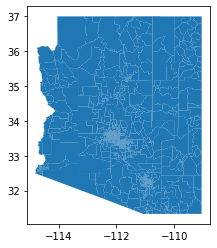

In [40]:
gdf.plot()

**Note that shapefile field names are limited to 10 characters. Check to ensure that all columns are named with fewer than 10 characters.**

In [41]:
shp_name = 'az_prim_20_prec'
create_erj_shp(gdf, shp_name)

az_prim_20_prec shapefile created.


### **Grab candidate/party info as dict for readme**

In [42]:
df_owri = df[df['is_write_in']=='true']
df['candidate_name_and_party'] = df['choice'] + ' (' + df['party'] + '), ' + df['contest']
field_id_dict = pd.Series(df['candidate_name_and_party'].values, index = df['field_id']).to_dict()

location_field_desc_dict ={'PCTNUM': 'Unique number identifier for precinct from VEST file', 'PRECINCTNA':'Non-unique precinct name/identifier from VEST file', 
'UNIQUE_ID': 'Unique precinct name/identifier from SOS file', 'CDE_COUNTY': "Two character county code from VEST's file", 
'COUNTY_NAM':'Name of county', 'COUNTYFP': 'Three digit county fips code', 'CON_DIST': 'US Representative district number', 
'SLDL_DIST': 'State Legislative Lower Level district number', 'SLDU_DIST': 'State Legislative Upper Level district number',
                          'geometry':'geometry'}
field_id_dict.update(location_field_desc_dict)

field_dict_for_readme = pd.Series(gdf.columns.map(field_id_dict).values, index = list(gdf.columns)).to_dict()
field_dict_for_readme

<ipython-input-42-2f3d451668c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['candidate_name_and_party'] = df['choice'] + ' (' + df['party'] + '), ' + df['contest']


{'UNIQUE_ID': 'Unique precinct name/identifier from SOS file',
 'COUNTYFP': 'Three digit county fips code',
 'PCTNUM': 'Unique number identifier for precinct from VEST file',
 'PRECINCTNA': 'Non-unique precinct name/identifier from VEST file',
 'CDE_COUNTY': "Two character county code from VEST's file",
 'COUNTY_NAM': 'Name of county',
 'CON_DIST': 'US Representative district number',
 'SLDL_DIST': 'State Legislative Lower Level district number',
 'SLDU_DIST': 'State Legislative Upper Level district number',
 'P20USSDKEL': 'Kelly, Mark (DEM), U.S. Senator (DEM)',
 'P20USSRMCC': 'McCarthy, Daniel "Demand Daniel" (REP), U.S. Senator (REP)',
 'P20USSRMCS': 'McSally, Martha (REP), U.S. Senator (REP)',
 'PCON01DOHA': "O'Halleran, Tom (DEM), U.S. Representative in Congress - District No. 1 (DEM)",
 'PCON01DPUT': 'Putzova, Eva (DEM), U.S. Representative in Congress - District No. 1 (DEM)',
 'PCON01RREI': 'Reidhead, Nolan (REP), U.S. Representative in Congress - District No. 1 (REP)',
 'PCON01

## Insert readme

In [44]:
def create_fields_table(race_field_header_0, fields_dict_0, 
                        add_race_field_header_1 = '', fields_dict_1 = {}, 
                        add_race_field_header_2 = '', fields_dict_2 = {}, 
                        add_race_field_header_3 = '', fields_dict_3 = {}):
    '''Purpose: Create fields table used in readme based on field dictionary created separately
    Arguments:
        race_field_header_0: include asterisks "***text***" and label first set of fields
        fields_dict_0: the default dictionary for the primary file (statewide)
        add_race_field_header_1: include asterisks to draw attention to section - ex: "***additional_race_file_name_fields***"
        fields_dict_1: additional fields to go under add_race_field_header_1 header
        add_race_field_header_2 and _3: same use as add_race_field_header_1 - include as needed
        fields_dict_2 and _3: same use as fields_dict_1 - include as needed associated with corresponding add_race_field_header section
    '''
    fields_table_data = {'Field Name': [''] + list(fields_dict_0.keys()) +
                         ['',''] + list(fields_dict_1.keys()) +
                         ['',''] + list(fields_dict_2.keys()) +
                         ['',''] + list(fields_dict_3.keys()),
                         'Description': [race_field_header_0] + list(fields_dict_0.values()) + 
                         ['',add_race_field_header_1] + list(fields_dict_1.values()) + 
                         ['',add_race_field_header_2] + list(fields_dict_2.values()) +
                         ['',add_race_field_header_3] + list(fields_dict_3.values())}
    fields_table = pd.DataFrame(fields_table_data)
    return fields_table

def erj_readme_template(stateabrv, state, year, election_type, additional_races, retrieval_date, vest_file_link, 
                        raw_data_source, state_erj_repo, office_codes, 
                        race_field_header_0, fields_dict_0, add_race_field_header_1 = '', fields_dict_1 = {}, add_race_field_header_2 = '', fields_dict_2 = {}, 
                        add_race_field_header_3 = '', fields_dict_3 = {},
                       additional_notes=' '):
    
    '''Purpose: standardize language in ERJ file README.txt
    Arguemts:
        fields_dict = used to create the fields table for the non-standardized/race fields fields. 
                    Key is the field/value is the field description
        stateabrv = two character state abbreviation capitalized, 
        state = state name, first letter capitalized, 
        year = election year (XXXX), 
        election_type = general, primary, special or runoff, 
        additional_races = the races that RDH added to the original vest file (not in VEST's og file), 
        retrieval_date = date RDH retrieved VEST file, 
        vest_file_link = link to dataverse page for VEST's precinct boundary and election results file, 
        raw_data_source = site description and link, 
        state_erj_repo = link to erj github repository for given state
        office_codes = codes used broken off of field names for easy viewing. 
            For SU/SL/CON, include ##, so SU## for office code
        race_field_header_0: include asterisks "***text***" and label first set of fields
        fields_dict_0: the default dictionary for the primary file (statewide)
        add_race_field_header_1: include asterisks to draw attention to section - ex: "***additional_race_file_name_fields***"
        fields_dict_1: additional fields to go under add_race_field_header_1 header
        add_race_field_header_2 and _3: same use as add_race_field_header_1 - include as needed
        fields_dict_2 and _3: same use as fields_dict_1 - include as needed associated with corresponding add_race_field_header section
        additional_notes = default set to empty, but fill in with string where applicable.
    '''
    
#First section of README
    readme_p1 = '''{year} {stateabrv} {election_type} Precinct Boundary and Election Results

## RDH Date Retrieval
{retrieval_date}

## Sources
The RDH retrieved the VEST {year} {election_type} precinct boundary and election results shapefile from [VEST's Harvard Dataverse]({vest_file_link})
The RDH retrieved raw {year} {election_type} election results from {raw_data_source}

## Notes on Field Names (adapted from VEST):
Columns reporting votes generally follow the pattern: 
The first character is G for a general election, P for a primary, S for a special, and R for a runoff.
Characters 2 and 3 are the year of the election.*
Characters 4-6 represent the office type (see list below).
Character 7 represents the party of the candidate.
Characters 8-10 are the first three letters of the candidate's last name.
One example is:
G16PREDCLI

To fit within the GIS 10 character limit for field names, the naming convention is slightly different for the State Legislature and 
US House of Representatives. All fields are listed below with definitions.

Office Codes Used:
{office_codes}

## Fields:

'''.format(stateabrv= stateabrv, state= state, year=year, election_type=election_type, additional_races=additional_races,retrieval_date=retrieval_date, vest_file_link=vest_file_link, raw_data_source=raw_data_source, state_erj_repo=state_erj_repo, office_codes=office_codes)

#Second section of README
    fields_table = create_fields_table(race_field_header_0, fields_dict_0, add_race_field_header_1, fields_dict_1, add_race_field_header_2, fields_dict_2, 
                        add_race_field_header_3, fields_dict_3).to_string(index=False)
    readme_p2 = str(fields_table)

#Third section of README
    readme_p3 = '''
## Processing Steps
    
The RDH joined additional election results to VEST's existing precinct shapefile, including {additional_races} using Python.
For more information on the processing completed, visit our [Github repository]({state_erj_repo}) for Election Result Joins (ERJ) for {state}.

Where possible, the RDH validated the election results we processed against VEST's election results. For additional races the RDH manually checked state totals. For more information on this comparison, please see our processing on Github ({state_erj_repo}).

## Additional Notes
{additional_notes}

Please contact info@redistrictingdatahub.org for more information.
'''.format(stateabrv=stateabrv, state=state, year=year, election_type=election_type, additional_races=additional_races, state_erj_repo=state_erj_repo, office_codes=office_codes, additional_notes = additional_notes)
    
    full_readme = str(readme_p1)+str(readme_p2)+str(readme_p3)
    return full_readme

In [45]:
# Define varibales used in readme
fields_dict =field_dict_for_readme
stateabrv = 'AZ'
state = 'Arizona'
year = '2020'
election_type = 'Primary'
additional_races = 'House of Representatives, US Senate, SLDL, SLDU, and Corporation Commissioner'
retrieval_date = '02/02/2022'
vest_file_link = 'https://dataverse.harvard.edu/file.xhtml?fileId=4864722&version=27.0'
raw_data_source = "[Arizona's Secretary of State website](https://azsos.gov/2020-election-information)"
state_erj_repo = "https://github.com/nonpartisan-redistricting-datahub/erj-az"
office_codes = '''CON## - U.S. House, accompanied by a CON_DIST column indicating district number
COC - Corporation Commissioner
USS - U.S. Senate
SU## - State Legislative Upper District, accompanied by a SLDU_DIST column indicating district number
SL## - State Legislative Lower District, accompanied by a SLDL_DIST column indicating district number
'''
additional_notes = '''The AZ Presidential Preference Election took place on March 17, 2020 and results are available
as a PDF from the SOS (https://azsos.gov/sites/default/files/PPE%20Canvass%20Signed%203.30.2020.pdf). 
The RDH did not process them at this time as they were not available at the precinct level, nor 
included outside of the PDF.

Note in Maricopa County the results from the SOS website (https://azsos.gov/2020-election-information) do not match the official Canvas of Results from 
the SOS and from Maricopa County's website. The RDH spoke with Maricopa County on 2/18/22 and was not able to determine a 
resolution based on that conversation. This descrepency led to differences in state total counts when compared with the PDF Canvas of Results.
'''
race_field_header_0=''
fields_dict_0 = field_dict_for_readme
#Run and sample readme - check print to make sure as expected
print(erj_readme_template(stateabrv, state, year, election_type, additional_races, retrieval_date, vest_file_link, 
                        raw_data_source, state_erj_repo, office_codes, 
                        race_field_header_0, fields_dict_0, additional_notes = additional_notes))

2020 AZ Primary Precinct Boundary and Election Results

## RDH Date Retrieval
02/02/2022

## Sources
The RDH retrieved the VEST 2020 Primary precinct boundary and election results shapefile from [VEST's Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?fileId=4864722&version=27.0)
The RDH retrieved raw 2020 Primary election results from [Arizona's Secretary of State website](https://azsos.gov/2020-election-information)

## Notes on Field Names (adapted from VEST):
Columns reporting votes generally follow the pattern: 
The first character is G for a general election, P for a primary, S for a special, and R for a runoff.
Characters 2 and 3 are the year of the election.*
Characters 4-6 represent the office type (see list below).
Character 7 represents the party of the candidate.
Characters 8-10 are the first three letters of the candidate's last name.
One example is:
G16PREDCLI

To fit within the GIS 10 character limit for field names, the naming convention is slightly different

In [49]:
full_readme = erj_readme_template(stateabrv, state, year, election_type, additional_races, retrieval_date, vest_file_link, 
                        raw_data_source, state_erj_repo, office_codes, 
                        race_field_header_0, fields_dict_0, additional_notes = additional_notes)
readme_name_for_zip = './az_prim_20_prec/readme.txt'
export_readme(readme_name_for_zip, state, election_type, full_readme)

readme_name_for_wp = './readme_az_prim_20_prec.txt'
export_readme(readme_name_for_wp, state, election_type, full_readme)

Arizona Primary  readme moved to folder


FileExistsError: [Errno 17] File exists: './readme_az_prim_20_prec.txt'

**precinct names joined on SOS names, then can still pull in the vest identifier**
- Then join together with polished column order
- Edit readme

**Then file complete and need to edit general file and disaggregate both.**